<a href="https://colab.research.google.com/github/momowade221/Notebook_Segmentation_Client_OM/blob/dev/Scoring_multisim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONFIGURATION**

---



In [1]:
#!pip install pyspark

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Colab/Segmentation/
myPath='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
"""
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import *
from pyspark.ml.feature import *
from pyspark.ml import *
from pyspark.ml.clustering import *
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.column import Column
"""
import sklearn
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.neighbors import *
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from tabulate import tabulate
from collections import Counter

"""
spark = SparkSession.builder.appName("Transactions_OM").getOrCreate()
spark
"""

Mounted at /content/drive
/content/drive/MyDrive/Colab/Segmentation


'\nspark = SparkSession.builder.appName("Transactions_OM").getOrCreate()\nspark\n'

# **PRÉPARATION DES DONNÉES**

---



## **Collection des données**

In [4]:
def df_load(path):
    # Charger le DataFrame depuis le fichier CSV avec les colonnes existantes
    df_loaded= spark.read.csv(f'{path}', header=True)
    # BaseTransaction OM - Renommer les colonnes
    #new_column_names = [col_name.replace(f"{table}.", "") for col_name in df_loaded.columns]
    #df_loaded = df_loaded.toDF(*new_column_names)
    return df_loaded

def pd_load(path):
    # Charger le DataFrame depuis le fichier CSV avec les colonnes existantes
    pd_loaded = pd.read_csv(path)
    # Renommer les colonnes
    # pd_loaded.columns = [col.replace(f"{table}.", "") for col in pd_loaded.columns]
    return pd_loaded

In [5]:
# Données roaming
#df_roaming=df_load(f'{myPath}/segmentation_multi_sim.csv')
#pd_roaming=pd_load(f'{myPath}/segmentation_multi_sim.csv')

#df_reporting_multisim=df_load(f'{myPath}/refined_reporting_multisim.csv')
pd_total_multisim=pd_load(f'{myPath}/multisim_total.csv')
pd_reporting_multisim=pd_load(f'{myPath}/refined_reporting_multisim.csv')

In [4]:
"""
# SICO
df_sico=df_load(f'{myPath}/segmentation_sico.csv')
# pd_sico = pd_load(f'{myPath}/segmentation_sico.csv')

#OM
df_transaction_om=df_load(f'{myPath}/segmentation_base_transaction_om.csv')
# pd_transaction_om = pd_load(f'{myPath}/segmentation_base_transaction_om.csv'

#Localisaion
df_location_night=df_load(f'{myPath}/vente_rebond_location_night.csv')
#pd_localisation=pd_load(f'{myPath}/vente_rebond_location_night.csv')

#Résultats segmentation
df_segment_rfm=df_load(f'{myPath}/segmentation_valeur_rfm.csv').drop("score_R","score_F","score_M")
pd_segment_rfm=pd_load(f'{myPath}/segmentation_valeur_rfm.csv').drop(["score_R","score_F","score_M"], axis=1)

df_kmeans_encoded_loaded=df_load(f'{myPath}/dataset_kmeans_encoded.csv')
pd_kmeans_encoded_loaded=pd_load(f'{myPath}/dataset_kmeans_encoded.csv')

#Segments Recharge
df_recharge=df_load(f'{myPath}/vente_rebond_recharge_in_details.csv')
df_segmentation_client=df_load(f'{myPath}/segmentation_client.csv')

# df_segment_recharge=df_load(f'{myPath}/segmentation_recharge_segment.csv')
# pd_segment_recharge=pd_load(f'{myPath}/segmentation_recharge_segment.csv')

#dataset kmeans
df_kmeans_init_loaded=df_load(f'{myPath}/dataset_kmeans_initial.csv')
pd_kmeans_init_loaded=pd_load(f'{myPath}/dataset_kmeans_initial.csv')

#Segment multisim
df_segment_multisim_loaded=df_load(f'{myPath}/segment_multisim_created.csv')
pd_segment_multisim_loaded=pd_load(f'{myPath}/segment_multisim_created.csv')

"""

'\n# SICO\ndf_sico=df_load(f\'{myPath}/segmentation_sico.csv\')\n# pd_sico = pd_load(f\'{myPath}/segmentation_sico.csv\')\n\n#OM\ndf_transaction_om=df_load(f\'{myPath}/segmentation_base_transaction_om.csv\')\n# pd_transaction_om = pd_load(f\'{myPath}/segmentation_base_transaction_om.csv\'\n\n#Localisaion\ndf_location_night=df_load(f\'{myPath}/vente_rebond_location_night.csv\')\n#pd_localisation=pd_load(f\'{myPath}/vente_rebond_location_night.csv\')\n\n#Résultats segmentation\ndf_segment_rfm=df_load(f\'{myPath}/segmentation_valeur_rfm.csv\').drop("score_R","score_F","score_M")\npd_segment_rfm=pd_load(f\'{myPath}/segmentation_valeur_rfm.csv\').drop(["score_R","score_F","score_M"], axis=1)\n\ndf_kmeans_encoded_loaded=df_load(f\'{myPath}/dataset_kmeans_encoded.csv\')\npd_kmeans_encoded_loaded=pd_load(f\'{myPath}/dataset_kmeans_encoded.csv\')\n\n#Segments Recharge\ndf_recharge=df_load(f\'{myPath}/vente_rebond_recharge_in_details.csv\')\ndf_segmentation_client=df_load(f\'{myPath}/segmentatio

## **Définition des fonctions d'exploration**

In [9]:
def df_info(df):
   # Informations sur le schéma du DataFrame
   ############ Info ###########")
   print(f"Nombre de features: {len(df.columns)}")
   df.printSchema()

   # Noms des colonnes
   ############ Colonnes ###########")
   print(df.columns)

   # Dimensions (nombre de lignes et de colonnes)
   ############ Dimensions ###########")
   num_rows = df.count()
   num_cols = len(df.columns)
   print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

   # Afficher les premières lignes (les 5 premières lignes sans troncature)
   ############ Premières lignes ###########")
   df.show(5, truncate=False)  # Affiche les 5 premières lignes sans troncature

   # Afficher les dernières lignes (les 5 dernières lignes triées par la première colonne en ordre décroissant)
   print("\n########### Dernières lignes ###########")
   df.orderBy(df.columns[0], ascending=False).show(5, truncate=False)  # Affiche les 5 dernières lignes

   # Statistiques sommaires (quantiles) du DataFram
   print("\n########### Statistiques sommaires ###########")
   df.summary().show()


def df_info_detailed(df):
  df_info(df)

  # Données manquantes (NA)
  print("\n########### Données manquantes ###########")
  # Compter le nombre de valeurs manquantes (NA) par colonne
  count_NA = df.agg(*[sum(df[c].isNull().cast("int")).alias(c) for c in df.columns])
  # Afficher le résultat
  print("Le nombre de colonnes qui contiennent des valeurs manquantes (NA)")
  count_NA.show()

  # Compter les occurrences de "NULL" dans chaque colonne
  count_exprs = [expr(f"sum(case when {c} like '%NULL%' then 1 else 0 end) as {c}_count") for c in df.columns]
  print("Le nombre de lignes qui contiennent la chaîne 'NULL'")
  count_NULL = df.select(*count_exprs)
  count_NULL.show()

  # Données dupliquées
  print("\n########### Données dupliquées ###########")

  # Find rows where all column values are identical
  duplicate_rows=df.groupBy(*df.columns).agg(count("*").alias("count"))
  duplicate_rows = duplicate_rows.filter(duplicate_rows["count"] > 1).select(*df.columns)

  if duplicate_rows.count()==0:
    print("Aucune ligne dupliquée trouvée")
  else:
    print(f"Nombre de données dupliquées : {duplicate_rows.count()}")
    # Show the rows with identical value
    duplicate_rows.show()

#Fonction pour afficher un DataFrame PySpark sous forme de Pandas DataFrame
def printdf(df):
    return df.toPandas()


In [10]:
import pandas as pd

# Fonction pour afficher des informations sur un DataFrame Pandas
def pd_info(df):

    # Informations sur le schéma du DataFrame
    print("########### Info ###########")
    print(df.dtypes)

    # Noms des colonnes
    print("########### Colonnes ###########")
    print(df.columns)

    # Dimensions (nombre de lignes et de colonnes)
    print("########### Dimensions ###########")
    num_rows, num_cols = df.shape
    print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

    # Afficher les premières lignes (les 5 premières lignes)
    print("########### Premières lignes ###########")
    print(df.head())

    # Afficher les dernières lignes (les 5 dernières lignes)
    print("########### Dernières lignes ###########")
    print(df.tail())

    # Statistiques sommaires (descriptives) du DataFrame
    print("\n########### Statistiques sommaires ###########")
    print(df.describe())

# Fonction pour afficher des informations détaillées sur un DataFrame Pandas
def df_info_detailed_pandas(df):
    df_info_pandas(df)

    # Données manquantes (NA)
    print("\n########### Données manquantes ###########")
    # Compter le nombre de valeurs manquantes (NA) par colonne
    missing_data = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne :")
    print(missing_data)

    # Compter les occurrences de "NULL" dans chaque colonne
    count_NULL = df.apply(lambda col: col.str.contains('NULL').sum())
    print("Nombre d'occurrences de 'NULL' par colonne :")
    print(count_NULL)

    # Données dupliquées
    print("\n########### Données dupliquées ###########")
    duplicate_rows = df[df.duplicated(keep=False)]

    if duplicate_rows.shape[0] == 0:
        print("Aucune ligne dupliquée trouvée")
    else:
        print(f"Nombre de données dupliquées : {duplicate_rows.shape[0]}")
        print("Lignes avec données dupliquées :")
        print(duplicate_rows)

# Fonction pour afficher un DataFrame Pandas
def printdf_pandas(df):
    return df


In [11]:
# from pyspark.sql import functions as F
def df_colonne_info(df, colonne):
    # Nombre de valeurs distinctes dans la colonne
    colonne_count = df.select(colonne).distinct().count()

    # Récupérer le type de données de la colonne
    colonne_type = df.schema[colonne].dataType

    # Affichage des informations
    print(f" *****Informations sur la colonne ___{colonne}___: *****")
    # Valeurs distinctes de la colonne
    print(f"Les valeurs distinctes sont:")
    df.select(colonne).distinct().show(truncate=False)

    print(f"Nombre de valeurs distinctes : {colonne_count}")

    if isinstance(colonne_type, (FloatType,DecimalType, IntegerType)):
        # Statistiques de base sur la colonne (moyenne, écart type, minimum, maximum)
        mean = df.select(mean(colonne)).first()[0]
        stddev = df.select(stddev(colonne)).first()[0]
        min_value = df.select(min(colonne)).first()[0]
        max_value = df.select(max(colonne)).first()[0]

        # Somme des valeurs dans la colonne
        sum_value = df.select(sum(colonne)).first()[0]

        # Médiane de la colonne
        median = df.approxQuantile(colonne, [0.5], 0.01)[0]

        # 1er quartile (Q1) et 3e quartile (Q3)
        quartiles = df.approxQuantile(colonne, [0.25, 0.75], 0.01)
        q1, q3 = quartiles

        print(f"Valeur moyenne : {mean}")
        print(f"Écart type : {stddev}")
        print(f"Valeur minimale : {min_value}")
        print(f"Valeur maximale : {max_value}")
        print(f"Somme des valeurs : {sum_value}")
        print(f"Médiane : {median}")
        print(f"1er quartile (Q1) : {q1}")
        print(f"3e quartile (Q3) : {q3}")
    else:
        print("Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.")

    print("-------------------------------------------------------")


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_colonne_distribution(dataframe, column):
    # Check if the specified column exists in the DataFrame
    if column not in dataframe.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    # Create a countplot with a custom color palette
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")

    custom_palette = sns.color_palette("husl")

    sns.countplot(x=column, data=dataframe, palette=custom_palette)

    # Calculate the total number of entries
    total_count = len(dataframe)

    # Annotate the bars with percentages
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    # Modify the y-axis label and title
    ax.set_ylabel('Nombre de clients')
    ax.set_title(f'Répartition des clients par {column}')

    # Rotate the x-axis labels by 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Increase the font size
    ax.tick_params(axis='both', labelsize=14)

    plt.show()

In [13]:
def plot_age_distribution(data, age_column, interval=10):
    bins = list(range(0, 101, interval))
    labels = [f"{i}-{i+interval-1}" for i in range(0, 100, interval)]  # Adjusted the range

    age_groups = pd.cut(data[age_column], bins=bins, labels=labels, right=False)
    data['age_group'] = age_groups

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")

    custom_palette = sns.color_palette("husl", n_colors=len(data['age_group'].unique()))

    sns.countplot(x='age_group', data=data, palette=custom_palette, ax=ax, hue='age_group', legend=False)

    total_count = len(data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    ax.set_ylabel('Nombre de clients')
    ax.set_title(f"Répartition des clients par tranche d'âge")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    ax.xaxis.set_major_locator(plt.MaxNLocator(len(data['age_group'].unique())))
    ax.tick_params(axis='both', labelsize=14)

    plt.show()


def plot_anciennete_distribution(data, age_column, interval=10):
    max_age = int(data[age_column].max())  # Convert max_age to integer
    bins = list(range(0, max_age + interval, interval))
    labels = [f"{i}-{i+interval-1}" for i in range(0, max_age, interval)]  # Adjusted the range

    age_groups = pd.cut(data[age_column], bins=bins, labels=labels, right=False)
    data['anciennete_groupes'] = age_groups

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")

    custom_palette = sns.color_palette("husl", n_colors=len(data['anciennete_groupes'].unique()))

    sns.countplot(x='anciennete_groupes', data=data, palette=custom_palette, ax=ax, hue='anciennete_groupes', legend=False)

    total_count = len(data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    ax.set_ylabel('Nombre de clients')
    ax.set_title(f"Répartition des clients par tranche d'ancienneté")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    ax.xaxis.set_major_locator(plt.MaxNLocator(len(data['anciennete_groupes'].unique())))
    ax.tick_params(axis='both', labelsize=14)

    plt.show()

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_colonne_heatmap(data, colonne):
    # Comptez le nombre total de clients
    total_count = len(data)

    # Créez un DataFrame de fréquence des valeurs dans la colonne
    value_counts = data[colonne].value_counts().reset_index()
    value_counts.columns = [colonne, "Count"]

    # Créez un pivot table pour préparer les données au format heatmap
    pivot_table = value_counts.pivot_table(index=None, columns=colonne, values="Count", aggfunc="sum", fill_value=0)

    # Convertissez les valeurs en pourcentage par rapport au total
    pivot_table_percentage = (pivot_table / total_count) * 100

    fig, ax = plt.subplots(figsize=(15, 8))
    sns.set(style="whitegrid")

    # Utilisez la fonction heatmap de Seaborn pour afficher le tableau heatmap en pourcentage
    sns.heatmap(pivot_table_percentage, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)

    ax.set_xlabel(colonne)
    ax.set_ylabel("Pourcentage de clients")
    ax.set_title(f"Répartition des clients par {colonne} en pourcentage")

    plt.show()

# **SEGMENTATION MULTISIM**

## **Exploration des données**




In [ ]:
df_info_detailed(df_roaming)

In [ ]:
pd.set_option('display.float_format', lambda x: '{:.0f}'.format(x))
pd_segmentation_client.describe(include='all')

In [ ]:
df_info(df_segmentation_client)

In [ ]:
df_info(df_segment_rfm)

In [ ]:
df_info(df_recharge)

In [ ]:
df_info(df_sico)

## **Feature engineering**

In [ ]:
def create_df_location(df_location):
    # Renommez la colonne commune_arrondissement en "ville"
    df_loc_clients = df_location.select("msisdn", "ca_cr_commune")

    # Group by "numero" and select the most frequent "ville"
    df_clients_top_villes = df_loc_clients.groupBy("msisdn", "ca_cr_commune") \
        .agg(count("*").alias("count")) \
        .orderBy(desc("count")) \
        .groupBy("msisdn") \
        .agg(first("ca_cr_commune").alias("ca_cr_commune"))

    return df_clients_top_villes
def create_df_sico(df_sico):
    taken_columns_sico = ['nd', 'date_naissance', 'date_debut_engagement']
    df_km_sic = df_sico.select(taken_columns_sico)
    df_km_sic = df_km_sic.withColumn("anciennete", year(current_date()) - year("date_debut_engagement")).drop("date_debut_engagement") \
        .withColumn("age", year(current_date()) - year("date_naissance")).drop("date_naissance")
    return df_km_sic


df_sico_created=create_df_sico(df_sico)
df_location_client=create_df_location(df_location_night)
df_segment_multisim_init =  df_roaming.withColumn("segment_sim",when(col("multi_sim").isNull(), "Monosim").otherwise("Multisim"))
df_recharge_created = df_recharge.groupBy("msisdn").agg(avg("montant").alias("moyenne_montant_recharge"))
df_segment_rfm_created=df_segment_rfm.select("numero","segment_RFM")
df_segment_telco=df_segmentation_client.select("msisdn","segment_recharge","segment_marche")

In [ ]:
df_segment_multisim=df_segment_multisim_init.join(df_sico_created,df_roaming["caller_msisdn"] ==df_sico_created["nd"] , "left_outer")\
                                            .join(df_location_client,df_roaming["caller_msisdn"] ==df_location_client["msisdn"] , "left_outer")\
                                            .join(df_segment_rfm_created, df_roaming["caller_msisdn"] == df_segment_rfm_created["numero"], "left_outer") \
                                            .join(df_recharge_created, df_roaming["caller_msisdn"] == df_recharge_created["msisdn"], "left_outer") \
                                            .join(df_segment_telco, df_roaming["caller_msisdn"] == df_segment_telco["msisdn"], "left_outer") \
                                            .withColumn("numero",when(col("numero").isNull(), "Inactif OM").otherwise("Actif OM"))\
                                            .drop("equipment_identity","multi_sim","msisdn","nd") \
                                            .withColumnRenamed("numero", "statut_client_om")
df_segment_multisim.coalesce(1).write.csv(f"{myPath}/resultat_segmentation_multisim_csv", header=True, mode='overwrite')

## **Exploration de la segmentation MultiSim**

In [ ]:
pd_multisim0=pd_segment_multisim_loaded
pd_multisim1=pd_segment_multisim_loaded[pd_segment_multisim_loaded["segment_sim"]=="Monosim"]
pd_multisim2=pd_segment_multisim_loaded[pd_segment_multisim_loaded["segment_sim"]=="Multisim"]

pd_multisim_om0=pd_segment_multisim_loaded[pd_segment_multisim_loaded["statut_client_om"]=="Actif OM"]
pd_multisim_om1 = pd_segment_multisim_loaded[
    (pd_segment_multisim_loaded["statut_client_om"] == "Actif OM") &
    (pd_segment_multisim_loaded["segment_sim"] == "Monosim")
]
pd_multisim_om2 = pd_segment_multisim_loaded[
    (pd_segment_multisim_loaded["statut_client_om"] == "Actif OM") &
    (pd_segment_multisim_loaded["segment_sim"] == "Multisim")
]


#### Infos générales

In [ ]:
pd_segment_multisim_loaded[pd_segment_multisim_loaded["statut_client_om"]=="Actif OM"].head(20)

In [ ]:
df_segment_multisim_loaded.filter(col("statut_client_om")=="Actif OM").show(5)
df_segment_multisim_loaded.filter(col("statut_client_om")=="Inactif OM").show(5)
df_info_detailed(df_segment_multisim_loaded)

#### Pourcentage

In [ ]:
import pandas as pd

def afficher_pourcentage_colonne(dataframe, nom_colonne):
    total_lignes = len(dataframe)

    # Calcul des pourcentages
    pourcentages = dataframe[nom_colonne].value_counts(normalize=True) * 100

    # Affichage des pourcentages
    print(f"Pourcentage des valeurs dans la colonne '{nom_colonne}':")
    print(pourcentages)

import pandas as pd

def afficher_pourcentage_intervalles(dataframe, nom_colonne, intervalle):
    # Création des intervalles
    intervalles = pd.cut(dataframe[nom_colonne], bins=intervalle, include_lowest=True)

    # Calcul des pourcentages
    pourcentages = intervalles.value_counts(normalize=True, sort=False) * 100

    # Affichage des pourcentages
    print(f"Pourcentage des valeurs dans la colonne '{nom_colonne}' par intervalles:")
    print(pourcentages)


In [ ]:
colon=[]
print("clients monosim")
afficher_pourcentage_colonne(pd_multisim1, "segment_RFM")
print("\nclients multisim")
afficher_pourcentage_colonne(pd_multisim2, "segment_RFM")

In [ ]:
# Utilisation de la fonction avec le DataFrame pd_segment_multisim pour les colonnes "age" et "anciennete"
intervalle_age = [0, 20, 30, 40, 50, 60, 100]  # Exemple d'intervalle pour l'âge
intervalle_anciennete = [0, 5, 10, 15, 20,25, 30]  # Exemple d'intervalle pour l'ancienneté
print("clients monsim")
afficher_pourcentage_intervalles(pd_multisim1, "age", intervalle_age)
print("\nclients multisim")
afficher_pourcentage_intervalles(pd_multisim2, "age", intervalle_age)

#### Segment sim et Statut OM

In [ ]:
plot_colonne_distribution(pd_multisim0,"segment_sim")

In [ ]:
plot_colonne_distribution(pd_multisim2,"statut_client_om")

#### Segment RFM

In [ ]:
#SEGMENT RFM
colonne="segment_RFM"
print("LES CLIENTS AVEC OM \n\n")
plot_colonne_distribution(pd_multisim_om0,colonne)

In [ ]:
print("\n\nLES CLIENTS MONOSIM AVEC OM \n\n")
plot_colonne_distribution(pd_multisim_om1,colonne)

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM AVEC OM \n\n")
plot_colonne_distribution(pd_multisim_om2,colonne)

#### Segment recharge

In [ ]:
#SEGMENT RECHARGE
colonne="segment_recharge"
print("LES CLIENTS SANS DISTINCTION \n\n")
plot_colonne_distribution(pd_multisim0,colonne)

In [ ]:
print("\n\nLES CLIENTS MONOSIM \n\n")
plot_colonne_distribution(pd_multisim1,colonne)

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM \n\n")
plot_colonne_distribution(pd_multisim2,colonne)

#### Segment marché

In [ ]:
#SEGMENT MARCHE
colonne="segment_marche"
print("LES CLIENTS SANS DISTINCTION \n\n")
plot_colonne_distribution(pd_multisim0,colonne)

In [ ]:
print("\n\nLES CLIENTS MONOSIM \n\n")
plot_colonne_distribution(pd_multisim1,colonne)

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM \n\n")
plot_colonne_distribution(pd_multisim2,colonne)

#### Age

In [ ]:
#AGE
colonne="age"
print("LES CLIENTS SANS DISTINCTION \n\n")
plot_age_distribution(pd_multisim0,colonne,10)

In [ ]:
print("\n\nLES CLIENTS MONOSIM \n\n")
plot_age_distribution(pd_multisim1,colonne)

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM \n\n")
plot_age_distribution(pd_multisim2,colonne)

#### Anciennete

In [ ]:
# AGE
colonne = "anciennete"  # Replace with the actual column name
print("LES CLIENTS SANS DISTINCTION \n\n")
plot_anciennete_distribution(pd_multisim0, colonne, 5)

In [ ]:
print("\n\nLES CLIENTS MONOSIM \n\n")
plot_anciennete_distribution(pd_multisim1, colonne, 5)

In [ ]:
print("\n\n\n\nLES CLIENTS MULTISIM \n\n")
plot_anciennete_distribution(pd_multisim2, colonne,  5)

#### Communes

In [ ]:
df=pd_multisim0
top_communes = df['ca_cr_commune'].value_counts().head(30)
df_top_communes = df[df['ca_cr_commune'].isin(top_communes.index)]
plot_colonne_distribution(df_top_communes ,'ca_cr_commune')

In [ ]:
df=pd_multisim1
top_communes = df['ca_cr_commune'].value_counts().head(30)
df_top_communes = df[df['ca_cr_commune'].isin(top_communes.index)]
plot_colonne_distribution(df_top_communes ,'ca_cr_commune')

In [ ]:
df=pd_multisim2
top_communes = df['ca_cr_commune'].value_counts().head(30)
df_top_communes = df[df['ca_cr_commune'].isin(top_communes.index)]
plot_colonne_distribution(df_top_communes ,'ca_cr_commune')

# **SEGMENTATION SCORING MULTISIM**

## **Exploration du dataset**

In [ ]:
pd_reporting_multisim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345995 entries, 0 to 345994
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   msisdn                       345995 non-null  int64  
 1   imei                         236048 non-null  float64
 2   multi_sim                    149561 non-null  float64
 3   age                          339823 non-null  float64
 4   sex                          339721 non-null  object 
 5   segment_marche               339780 non-null  object 
 6   appel_orange_3_last_m        345995 non-null  float64
 7   appel_free_3_last_m          345995 non-null  float64
 8   appel_expresso_3_last_m      345995 non-null  float64
 9   min_appel_orange_3_last_m    345995 non-null  float64
 10  min_appel_free_3_last_m      345995 non-null  float64
 11  min_appel_expresso_3_last_m  345995 non-null  float64
 12  ca_cr_commune_day            345860 non-null  object 
 13 

In [7]:
pd_total_multisim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13019721 entries, 0 to 13019720
Data columns (total 14 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   numero                       int64  
 1   age                          float64
 2   sex                          object 
 3   segment_marche               object 
 4   appel_orange_3_last_m        float64
 5   appel_free_3_last_m          float64
 6   appel_expresso_3_last_m      float64
 7   min_appel_orange_3_last_m    float64
 8   min_appel_free_3_last_m      float64
 9   min_appel_expresso_3_last_m  float64
 10  ca_cr_commune_day            object 
 11  ca_cr_commune_night          object 
 12  usage_data_90j               float64
 13  top_appel                    object 
dtypes: float64(8), int64(1), object(5)
memory usage: 1.4+ GB


In [ ]:
pd_reporting_multisim.isna().sum()

<ipython-input-11-dc77555e12a3>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-dc77555e12a3>:15: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.countplot(x=column, data=dataframe, palette=custom_palette)
<ipython-input-11-dc77555e12a3>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


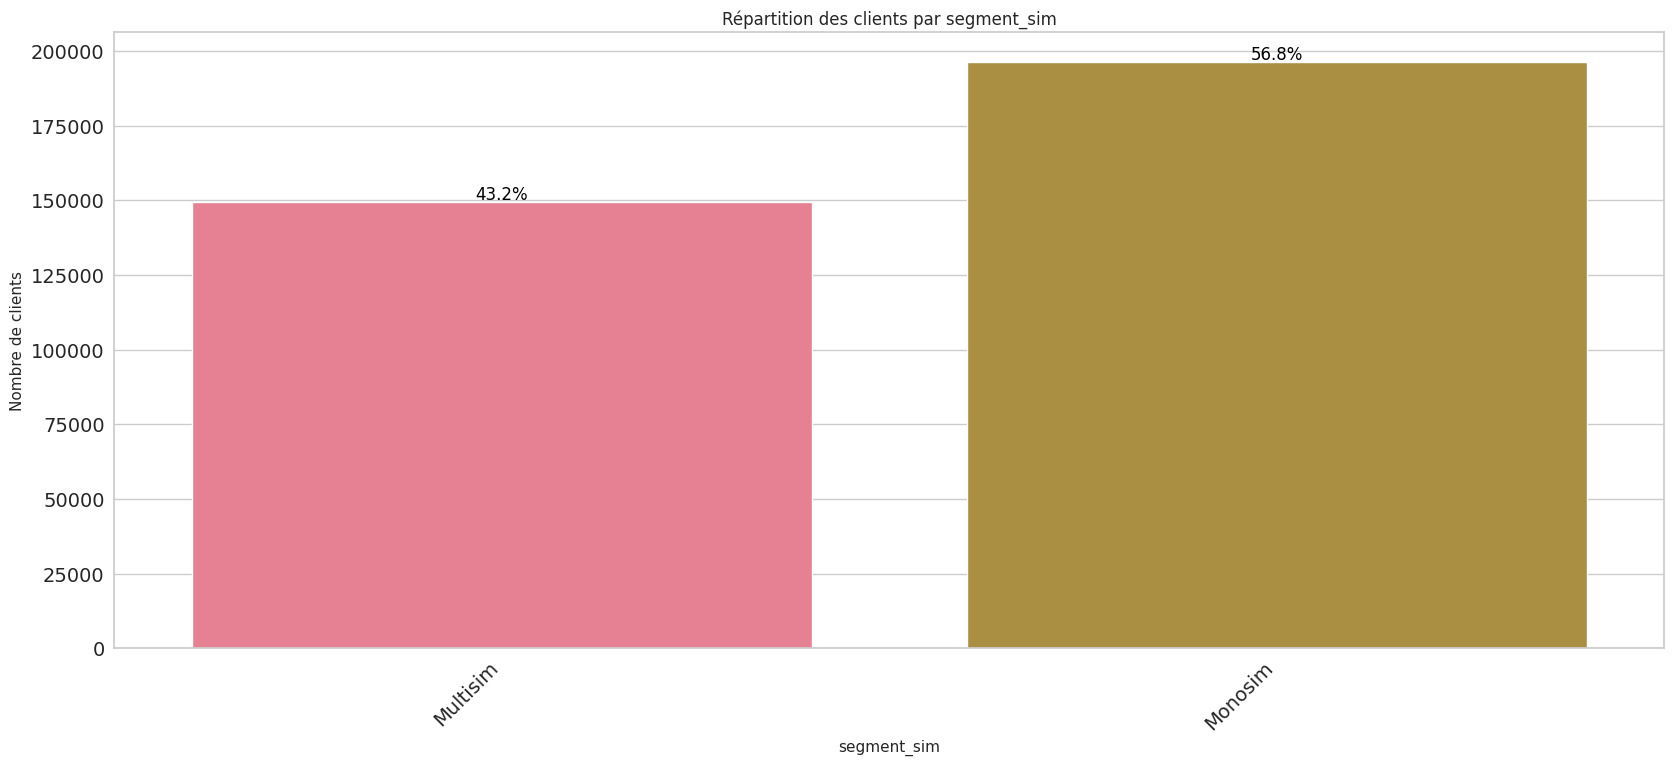

In [ ]:
pd_reporting_multisim_stat=  pd_reporting_multisim.copy()
pd_reporting_multisim_stat["segment_sim"] = pd_reporting_multisim_stat["multi_sim"].apply(lambda x: "Monosim" if pd.isna(x) else "Multisim")
plot_colonne_distribution(pd_reporting_multisim_stat,"segment_sim")

## **Feature engineering**

### Nettoyage et transformation

#### Imputation

In [9]:
def clean_data(df):
    # Copie du DataFrame pour éviter les modifications inattendues
    df_clean = df.copy().drop([ "ca_cr_commune_day"], axis=1)

    # Conversion de la colonne "msisdn" en type str
    #df_clean["msisdn"] = df_clean["msisdn"].astype(str)

    # Colonnes à nettoyer/remplir
    columns_to_clean = [
        'appel_orange_3_last_m', 'appel_free_3_last_m', 'appel_expresso_3_last_m',
        'min_appel_orange_3_last_m', 'min_appel_free_3_last_m', 'min_appel_expresso_3_last_m',
        'usage_data_90j'
    ]

    # Conversion des valeurs nulles des colonnes en zéro
    for column in columns_to_clean:
        df_clean[column] = df_clean[column].fillna(0)

    # Imputation de l'âge avec la moyenne
    age_mean = df_clean["age"].mean()
    df_clean["age"] = df_clean["age"].fillna(age_mean)

    # Imputation du sexe avec des valeurs aléatoires "M" ou "F"
    missing_sex_values_count = df["sex"].isnull().sum()
    df_clean.loc[df["sex"].isnull(), "sex"] = np.random.choice(["M", "F"], size=missing_sex_values_count)

    # Imputation des variables "segment_marche" et "ca_cr_commune_night" avec des valeurs par défaut
    df_clean["segment_marche"] = df_clean["segment_marche"].fillna("AUTRES")
    df_clean["ca_cr_commune_night"] = df_clean["ca_cr_commune_night"].fillna("Autres")

    return df_clean

# Exemple d'utilisation de la fonction sur votre DataFrame
# Remplacez pd_reporting_multisim par le nom de votre DataFrame
pd_reporting_multisim_clean = clean_data(pd_reporting_multisim.drop(["imei", "year", "month","top1", "top2", "top3", "top4", "top5"],axis=1))
pd_total_multisim_clean=clean_data(pd_total_multisim.drop("top_appel",axis=1))
pd_reporting_multisim_clean.info()
pd_total_multisim_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345995 entries, 0 to 345994
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   msisdn                       345995 non-null  int64  
 1   multi_sim                    149561 non-null  float64
 2   age                          345995 non-null  float64
 3   sex                          345995 non-null  object 
 4   segment_marche               345995 non-null  object 
 5   appel_orange_3_last_m        345995 non-null  float64
 6   appel_free_3_last_m          345995 non-null  float64
 7   appel_expresso_3_last_m      345995 non-null  float64
 8   min_appel_orange_3_last_m    345995 non-null  float64
 9   min_appel_free_3_last_m      345995 non-null  float64
 10  min_appel_expresso_3_last_m  345995 non-null  float64
 11  ca_cr_commune_night          345995 non-null  object 
 12  usage_data_90j               345995 non-null  float64
dtyp

#### Encodage

In [31]:
# Encodage des variables catégorielles
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

def encode_columns(df_to_encode, categorical_columns):
  df_encoded = df_to_encode.copy()
  # Encodage des variables catégorielles
  label_encoder = LabelEncoder()
  for col in categorical_columns:
      new_col_name = col + "_encoded"
      df_encoded[new_col_name] = label_encoder.fit_transform(df_encoded[col])
  return df_encoded


pd_reporting_multisim_encoded=pd_reporting_multisim_clean.copy()
pd_total_multisim_encoded=pd_total_multisim_clean.copy()
# Encoder la variable "multisim"
pd_reporting_multisim_encoded["multi_sim"] = pd_reporting_multisim_encoded["multi_sim"].apply(lambda x: 1 if pd.isna(x) else 2)

#Encoder les autres colonnes catégorielles
columns_to_encode=["sex","ca_cr_commune_night","segment_marche"]
pd_reporting_multisim_encoded=encode_columns(pd_reporting_multisim_encoded,columns_to_encode)
pd_total_multisim_encoded=encode_columns(pd_total_multisim_encoded,columns_to_encode)

### Pouvoir prédictif des variables

A l'aide de modèles de machine learning, classer les variables par leur pouvoir prédictif (pour prédire si un client est monosim 0 et multisim 1), et ne conserver que celles qui ont le plus fort impact sur la variable cible.

On applique pour la sélection de variables une régression logistique avec pénalité lasso : on supprimera les variables ayant un poids de 0 avec la pénalité lasso

<ipython-input-11-037b0975c7e8>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance des variables", y="Nom des variables",


Variables sélectionnées : Index(['age', 'appel_orange_3_last_m', 'appel_free_3_last_m',
       'appel_expresso_3_last_m', 'min_appel_orange_3_last_m',
       'min_appel_free_3_last_m', 'min_appel_expresso_3_last_m',
       'usage_data_90j', 'sex_encoded', 'segment_marche_encoded'],
      dtype='object')


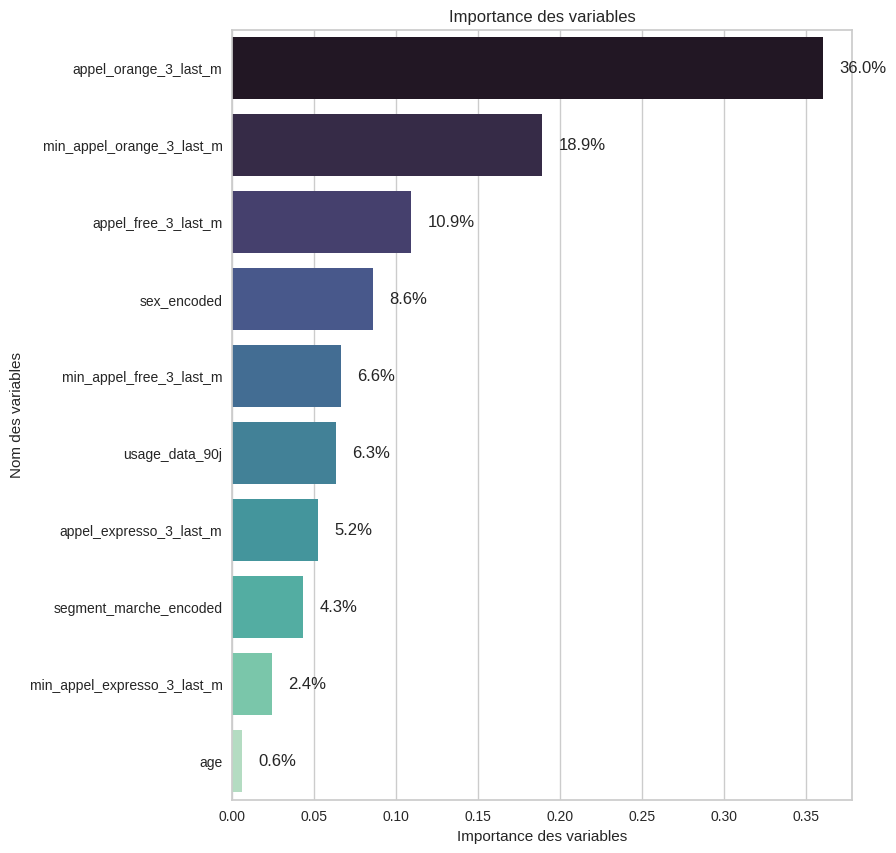

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

datafram=pd_reporting_multisim_encoded
# Supprimer les lignes avec des valeurs manquantes
datafram = datafram.dropna()

columns_to_drop=['multi_sim','msisdn', 'sex','ca_cr_commune_night','ca_cr_commune_night_encoded','segment_marche']
# Définir les variables indépendantes (X) et la variable cible (y)
X = datafram.drop(columns=columns_to_drop)  # Variables indépendantes
y = datafram['multi_sim']  # Variable cible

# Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliser les variables indépendantes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Appliquer la régression logistique avec pénalité Lasso
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train_scaled, y_train)

# Get the model coefficients after fitting
coef = model.coef_[0]

# Calculate importance based on absolute coefficient values
importance_abs = np.abs(coef) / np.sum(np.abs(coef))

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame(data={
    "Nom des variables": X.columns,
    "Importance des variables": importance_abs
})
feat_imp_df = feat_imp_df.sort_values("Importance des variables", ascending=False)


# Create the bar plot
fig, ax = plt.subplots(figsize=(8, 10))  # Adjust figure size as needed
sns.barplot(x="Importance des variables", y="Nom des variables",
            data=feat_imp_df, palette="mako", ax=ax)

# Annotate bars with percentage values
total = len(feat_imp_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width())
    x_pos = p.get_width() + 0.01
    y_pos = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x_pos, y_pos), ha='left', va='center')

# Afficher les coefficients non nuls (poids non nuls) après la pénalité Lasso
selected_features = X.columns[model.coef_[0] != 0]
print("Variables sélectionnées :", selected_features)

plt.title('Importance des variables')
plt.show()

### Sélection des variables

In [32]:
columns_to_delete=["segment_marche","sex","ca_cr_commune_night","ca_cr_commune_night_encoded"]
pd_reporting_multisim_fin = pd_reporting_multisim_encoded.copy().drop(columns_to_delete,axis=1)
pd_reporting_multisim_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345995 entries, 0 to 345994
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   msisdn                       345995 non-null  int64  
 1   multi_sim                    345995 non-null  int64  
 2   age                          345995 non-null  float64
 3   appel_orange_3_last_m        345995 non-null  float64
 4   appel_free_3_last_m          345995 non-null  float64
 5   appel_expresso_3_last_m      345995 non-null  float64
 6   min_appel_orange_3_last_m    345995 non-null  float64
 7   min_appel_free_3_last_m      345995 non-null  float64
 8   min_appel_expresso_3_last_m  345995 non-null  float64
 9   usage_data_90j               345995 non-null  float64
 10  sex_encoded                  345995 non-null  int64  
 11  segment_marche_encoded       345995 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 31.7 MB


In [33]:
pd_total_multisim_fin = pd_total_multisim_encoded.copy().drop(columns_to_delete,axis=1)
pd_total_multisim_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13019721 entries, 0 to 13019720
Data columns (total 11 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   numero                       int64  
 1   age                          float64
 2   appel_orange_3_last_m        float64
 3   appel_free_3_last_m          float64
 4   appel_expresso_3_last_m      float64
 5   min_appel_orange_3_last_m    float64
 6   min_appel_free_3_last_m      float64
 7   min_appel_expresso_3_last_m  float64
 8   usage_data_90j               float64
 9   sex_encoded                  int64  
 10  segment_marche_encoded       int64  
dtypes: float64(8), int64(3)
memory usage: 1.1 GB


### Corrélation

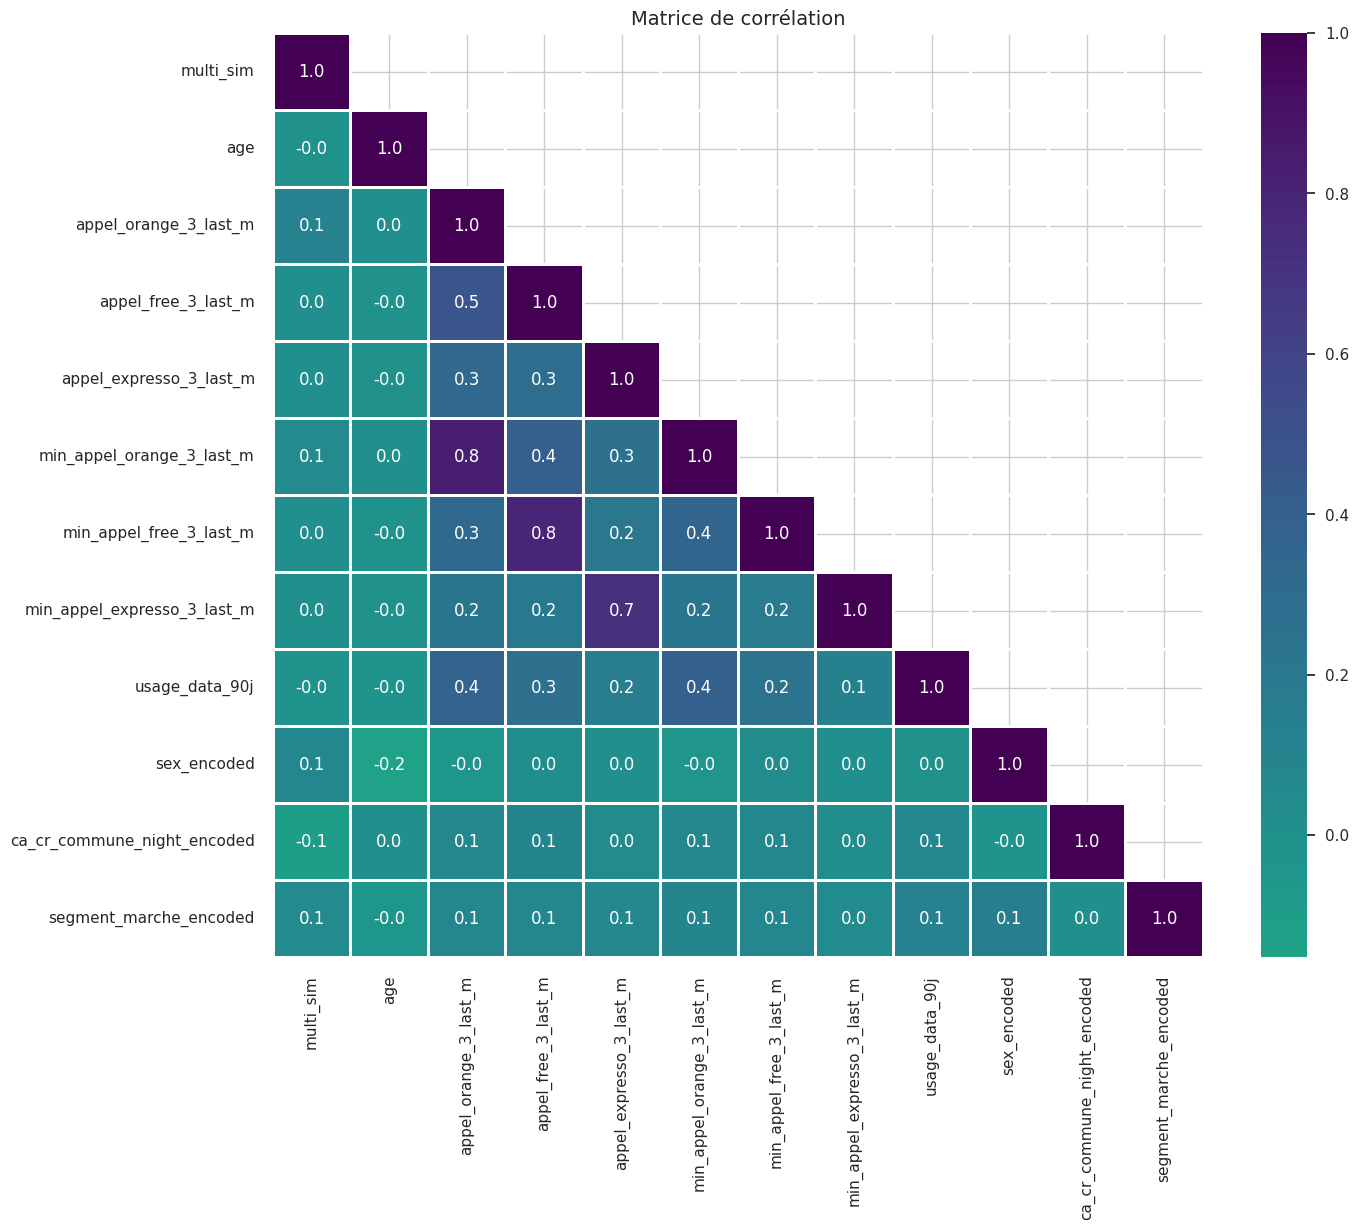

In [ ]:
def plot_correlation_matrix_multisim(dataframe):
    # Reset background style
    sns.set_style('whitegrid')

    # Calculate the correlation matrix excluding certain columns
    corr = dataframe.drop(columns=['msisdn']).corr()

    # Create a mask to only show the lower triangle of the matrix
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask, k=1)] = True

    # Plot the heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(corr, mask=mask, annot=True, center=0, cmap="viridis_r", fmt='.1f', linewidths=2)
    plt.title('Matrice de corrélation', fontsize=14)
    plt.show()

plot_correlation_matrix_multisim(pd_reporting_multisim_final)

### Découpage et normalisation des données

In [49]:
from sklearn.preprocessing import StandardScaler

# Séparation des features et de la cible
X = pd_reporting_multisim_final.drop(["msisdn", "multi_sim"], axis=1)
y = pd_reporting_multisim_final["multi_sim"]

# Split du dataset en ensemble d'entraînement et ensemble de test
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des features (mise à l'échelle)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)
X_test_scaled.shape

(69199, 10)

## **Entraînement des modèles**

### Fonctions d'évaluation des modèles

On crée des fonctions pour évaluer nos modèles :

In [14]:
import pandas as pd
from sklearn import metrics

def model_score(y, y_pred):
    acc = np.round(metrics.accuracy_score(y, y_pred)*100)
    prec =np.round( metrics.precision_score(y, y_pred)*100)
    sens =np.round( metrics.recall_score(y, y_pred)*100)
    f_1 = np.round(2 * (prec * sens) / (prec + sens))

    # Créer un dataframe pandas pour stocker les scores
    score_df = pd.DataFrame({
        'Metrique': ['Accuracy', 'Précision', 'Sensibilité', 'F1 Score'],
        'Score': [f"{acc}%", f"{prec}%", f"{sens}%", f"{f_1}%"]
    })

    return score_df

def matrice_conf(y, y_pred):
    # Calcul de la matrice de confusion
    cf = confusion_matrix(y, y_pred)
    # Calcul des pourcentages
    cf_percent = np.round(cf.astype('float') / np.sum(cf) * 100, decimals=2)

    # Définition des annotations personnalisées avec les pourcentages
    annotations = [['Vrais Monosim\n' + str(cf_percent[0, 0]) + '%', 'Faux Multisim\n' + str(cf_percent[0, 1]) + '%'],
                   ['Faux Monosim\n' + str(cf_percent[1, 0]) + '%', 'Vrais Multisim\n' + str(cf_percent[1, 1]) + '%']]

    # Affichage de la matrice de confusion avec seaborn
    sns.heatmap(cf_percent, annot=np.array(annotations), fmt='', cmap='Greens', cbar=False)


    # Affichage de la matrice de confusion avec seaborn
    sns.heatmap(cf_percent, annot=np.array(annotations), fmt='', cmap='Greens', cbar=False)
    # Définition des légendes personnalisées pour la matrice
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Matrice de Confusion en pourcentage')
    # Affichage de la matrice
    plt.show()

def learning_curve_nn(history):           #learning curve pour les réseaux de neurones
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def recap_model(dict_model,y):
    res=pd.DataFrame(index=list(dict_model.keys()))
    accu=[]
    prec=[]
    sens=[]
    f_1=[]
    somme=[]
    for key in dict_model.keys():
        a = metrics.accuracy_score(y,dict_model[key])
        p = metrics.precision_score(y,dict_model[key])
        s = metrics.recall_score(y,dict_model[key])
        f = 2*(p*s)/(p+s)

        accu.append(np.round(a,2))
        prec.append(np.round(p,2))
        f_1.append(np.round(f,2))
        sens.append(np.round(s,2))
    for i in range(len(accu)):
        somme.append(accu[i]+prec[i]+sens[i]+f_1[i])
    res["Accuracy"]=accu
    res["Précision"]=prec
    res["Sensibilité"]=sens
    res["Score F1"]=f_1
    res["Somme"]=somme

    res=res.sort_values(by = "Somme", ascending = False)
    return res

Pour vérifier la qualité des modèles que nous utiliserons, nous calculerons à chaque fois avec la fonction model_score ci-dessus différents scores :

- L'**Accuracy** ou taux de succès : proportion des composants correctement classés par le modèle.
- La **Précision** : proportion, parmi les composants classés comme multisim par le modèle, de ceux qui sont bien multisim
- La **Sensibilité** : proportion, parmi les composants multisim, de ceux qui ont bien été classés comme multisim par le modèle.
- Le score **F1** est la moyenne harmonique de la précision et de la sensibilité.

La précision donne donc le taux de vrais positifs parmi tous les composants classés comme "positifs" (multisim). Étudier ce score est donc particulièrement adapté ici, car nous sommes dans une situation où l'on veut éviter au maximum les faux positifs. En effet, un faux positif signifie ici considérer comme multisim un composant qui ne l'est pas, ce qui peut amener à des pollutions graves.

Dans le contexte où la classe positive est "multisim" (c'est-à-dire les observations appartenant à la classe "multisim") et la classe négative est "monosim" (c'est-à-dire les observations appartenant à la classe "monosim"), la matrice de confusion serait interprétée comme suit :

1. **Vrai Monosim (TN) - Vrais Monosim (C_{0,0}) :**
   - Le nombre d'observations qui sont réellement des monosims et qui ont été correctement prédites comme monosims par le modèle.

2. **Faux Multisim (FP) - Faux Multisim (C_{0,1}) :**
   - Le nombre d'observations qui sont réellement des monosims mais qui ont été incorrectement prédites comme multisims par le modèle.

3. **Faux Monosim (FN) - Faux Monosim (C_{1,0}) :**
   - Le nombre d'observations qui sont réellement des multisims mais qui ont été incorrectement prédites comme monosims par le modèle.

4. **Vrais Multisim (TP) - Vrais Multisim (C_{1,1}) :**
   - Le nombre d'observations qui sont réellement des multisims et qui ont été correctement prédites comme multisims par le modèle.

Dans ce cas, "multisim" est considéré comme la classe Multisim et "monosim" comme la classe négative. La matrice de confusion fournira des informations sur la performance du modèle dans la prédiction des classes "multisim" et "monosim".



Dans cette partie on va tester différents modèles. On crée un dictionnaire pour stocker nos modèles afin de pouvoir les comparer plus tard :

In [15]:
dict_models_pred={}

### Régression Logistique



Dans un premier temps avec la base de données classiques. On effectue une régression logistique avec cette fois-ci une pénalisation $\ell_{2}$. On affiche les scores du modèle et sa matrice de confusion. On effectue plusieurs tests pour choisir la constante de pénalisation C.

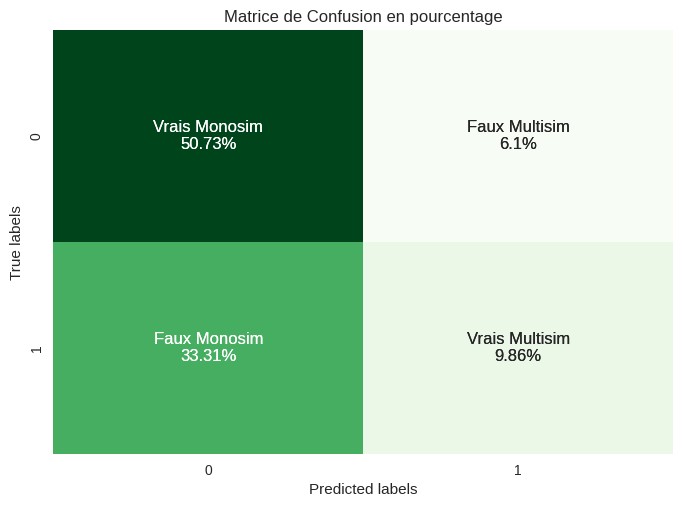

,Metrique,Score
0,Accuracy,61.0%
1,Précision,60.0%
2,Sensibilité,89.0%
3,F1 Score,72.0%


In [52]:
logRegB = LogisticRegression(penalty = "l2", C = 0.8)#On crée notre régression logistique
logRegB.fit(X_train_scaled,y_train_final)#On la fit à nos données
logRegB_pred = logRegB.predict(X_test_scaled)# On prédit nos données

"""
# Création d'un dataframe avec les probabilités prédites
probabilities = logRegB.predict_proba(X_test_scaled)[:, 1]
X_test_final['probabilites_predites'] = probabilities
X_test_final['label_reel'] = y_test_final
"""

dict_models_pred['Régression logistique']=logRegB_pred #On ajoute les résultats dans notre dictionnaire
matrice_conf(y_test_final,logRegB_pred)# Matrice de confusion
model_score(y_test_final,logRegB_pred) #Score

C_{0,0}:Vrai négatif, C_{1,0}: faux négatif, C_{1,1}: Vrai positif, C_{0,1} and faux positiF

### RandomForest



D'abord sur les données classiques. On utilise une forêt de 200 arbres :

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


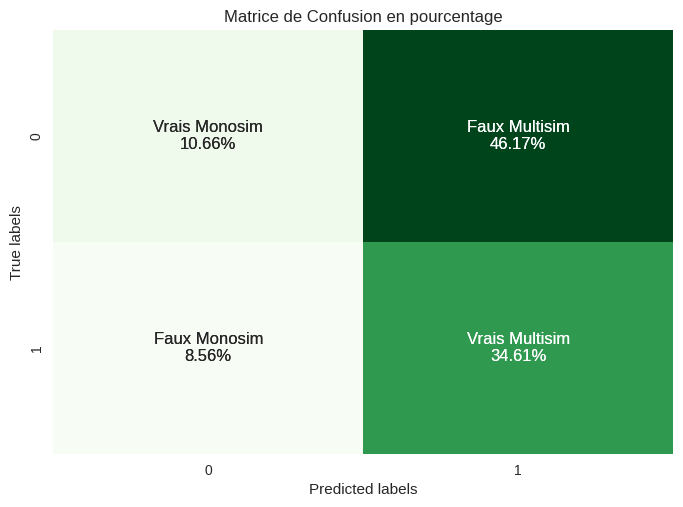

,Metrique,Score
0,Accuracy,45.0%
1,Précision,55.0%
2,Sensibilité,19.0%
3,F1 Score,28.0%


In [53]:
from sklearn.ensemble import RandomForestClassifier

rfB = RandomForestClassifier(n_estimators=200)#On crée notre RandomForest
rfB.fit(X_train_scaled,y_train_final)#On la fit à nos données
rfB_pred =rfB.predict(X_test_final) #On prédit nos données

dict_models_pred['Random Forest']=rfB_pred  #On ajoute les résultats dans notre dictionnaire

matrice_conf(y_test_final,rfB_pred) #Matrice de confusion
model_score(y_test_final,rfB_pred) #Score


### K plus proches voisins



Le modèle des **K plus proches voisins** (K nearest neighbours) consiste à prédire la catégorie d'un nouvel individu dans la variable cible (ici 1 ou 0, multisim ou non) en fonction de la catégorie majoritaire parmi les K individus qui sont les plus proches du nouveau dans le set d'entraînement :

On fixe un entier $K$, et on répertorie dans le set d'entraînement les $K$ individus qui sont les plus proches du nouvel individu, au sens de la distance euclidienne de $ \mathbb{R}^d $ (d le nombre de variables explicatives). Si parmi ces $K$ individus la catégorie majoritaire dans la variable cible est 1, on assigne à notre nouvel individu la valeur 1 pour la variable cible, sinon on lui assigne 0.

À noter que ce modèle est à utiliser avec parcimonie lorsqu'on a des variables catégorielles dans les données, car des variables discrètes induisent une topologie impropre et peuvent donc fausser les prédictions. C'est surtout vrai lorsque ces variables sont des nombres choisis arbitrairement pour coder une caractéristique (typiquement, dans notre cas, si experimental_class était une variable explicative) et ne correspondent à aucune donnée numérique réelle.

Le choix de $K$ est crucial pour ce modèle. Naturellement $K$ sera toujours pris impair pour qu'il n'y ait pas d'ex-æquo. Afin de déterminer le meilleur $K$, on va, pour chaque valeur $k$ entre 1 et 40, tester le modèle des $k$ plus proches voisins et calculer son taux d'erreur (proportion de mauvais classements sur la base de test). On choisira le $K$ qui donne le taux d'erreur le plus faible :

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

erreur=[]
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled,y_train_final)
    pred_i = knn.predict(X_test_final)
    erreur.append(np.mean(pred_i != y_test_final))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),erreur,color="blue",linestyle="dashed", marker="o",markerfacecolor="red", markersize=10)
plt.title("Taux d'erreur vs Nombre de Voisin ")
plt.xlabel("K")
plt.ylabel("Error Rate")

On choisit de prendre 3 voisins d'après le graphique. À noter qu'avec 9 voisins l'erreur est aussi basse qu'avec 3.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


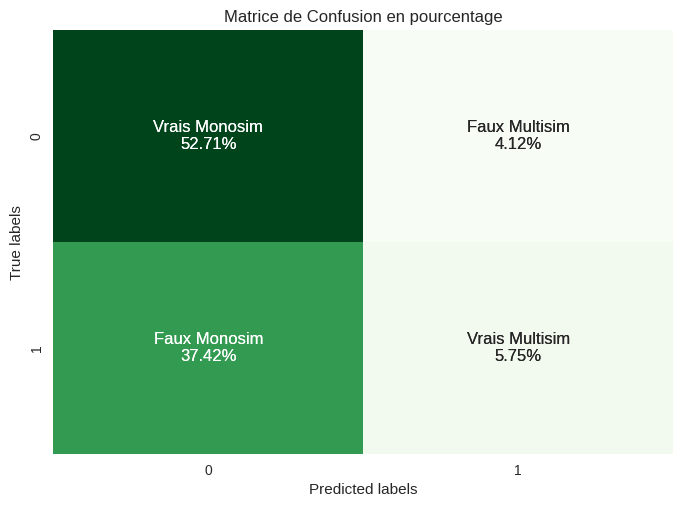

,Metrique,Score
0,Accuracy,58.0%
1,Précision,58.0%
2,Sensibilité,93.0%
3,F1 Score,71.0%


In [54]:
knnB = KNeighborsClassifier(n_neighbors=3)#On crée notre KNN
knnB.fit(X_train_scaled,y_train_final) #On la fit à nos données
knnB_pred = knnB.predict(X_test_final)# On prédit nos données

dict_models_pred['KNN']=knnB_pred  #On ajoute les résultats dans notre dictionnaire


matrice_conf(y_test_final,knnB_pred) #Matrice de confusion
model_score(y_test_final,knnB_pred) #Score

### SVM



Une **machine à vecteur de support linéaire** consiste à trouver un hyperplan (sous-espace de dimension $d-1$ si $d$ est la dimension de l'espace de départ) séparateur entre les points du dataset.

Pour $i = 1,\dots,N$ avec $N$ le nombre d'individus, soit $x_i \in \mathbb{R}^d $ nos points et $y_i$ les étiquettes associées (multisim ou non en l'occurrence). Dans la théorie mathématique du SVM, on prend 1 ou -1 comme valeurs pour les $y_i$ (le modèle implémenté s'adaptera tout seul en considérant les 0 comme des -1, il n'y a pas de modification à faire sur nos données).

Le but est de trouver $H = \{x \in \mathbb{R}^d : w^Tx + b = 0 \} $

Où $b \in \mathbb{R}$ est le déplacemet par rapport à l'origine et $w \in \mathbb{R}^d$ non-nul est le vecteur orthogonal à $H$. $H$ doit séparer le dataset en deux régions, une où les $y_i$ valent 1 et une où les $y_i$ valent -1.

<br>

On voudra choisir $H$ de façon à maximiser la marge, définie par $ \displaystyle \min_{i=1,\dots,N} d(x_i,H)$

Où $d(x_i,H)$ est la distance entre le points $x_i$ et $H$. Autrement dit on veut $H$ le plus éloigné possible des points (naturellement il ne doit passer par aucun point).

On peut montrer que la marge est aussi égale à $\frac{1}{\Vert w \Vert}$. Le problème revient donc à maximiser $\Vert w \Vert$

<br>
<br>

Naturellement les données ne sont en général pas **linéairement séparables**, c'est à dire qu'il n'est généralement pas possible de trouver un $H$ qui sépare parfaitement le dataset selon les deux catégories.

Afin de palier à ce problème, on introduit des **variables d'écart** $s_i$ (nombres positifs). Ces variables vont permettre d'autoriser quelques points à être du mauvais côté de $H$.

On cherchera alors à résoudre le problème d'optimisation suivant :

$ \displaystyle \min_{w \in \mathbb{R}^d, b\in \mathbb{R}, s \in \mathbb{R}^N} \displaystyle \frac{\Vert w \Vert^2_2}{2} + C \displaystyle \sum_{i=1}^{N} s_i $

Avec les contraintes : pour $i = 1,\dots,N$, $ y_i(w^Tx_i + b) \geq 1 - s_i$  et  $s_i \geq 0$

(avec $C>0$ une constante)

On peut montrer mathématiquement (en utilisant le lagrangien, les conditions KKT et l'étude de la dualité) que ce problème admet une unique solution.

Le modèle SVM implémenté va donc déterminer cette unique solution par des algorithmes d'optimisation, ce qui nous donnera l'hyperplan $H$. Une nouvelle observation sera classée multisim ou non selon de quel côté de $H$ elle se trouve.

In [ ]:
from sklearn.svm import SVC

svmB = SVC(kernel = 'linear')#On crée notre SVM
svmB.fit(X_train_scaled,y_train_final) #On la fit à nos données
svmB_pred =svmB.predict(X_test_final)# On prédit nos données

dict_models_pred['SVM']=svmB_pred  #On ajoute les résultats dans notre dictionnaire

model_score(y_test,svmB_pred) #Score
matrice_conf(y_test,svmB_pred) #Matrice de confusion

### AdaBoost



L'**adaptative boosting**, aussi appelé adaboost, est comme son nom l'indique une méthode de **boosting**.

Le boosting consiste à combiner par itérations successives des classeurs dits faibles pour obtenir un classifieur final (dit fort). Les classifieurs faibles sont des classifieurs capables de reconnaître deux classes au moins aussi bien que ne le ferait une sélection au hasard (c'est à dire la sélection qui consisterait dans notre cas présent à prédire un composant comme multisim selon une loi de Bernoulli dont le paramètre serait la proportion de biodégradables dans le jeu d'entraînement). Il est possible de démontrer que tant que les classifieurs faibles sont meilleurs qu'une prédiction aléatoire, la combinaison va converger vers un classifieur fort.

<br>

L'adaboost, forme la plus répandue de boosting, fait référence à une technique particulière pour combiner les classifieurs faibles : pour obtenir la sortie finale prédisant la valeur de la variable cible, on prend la somme pondérée des prédictions effectuées par les classifieurs faibles. Le poids assigné à un classifieur donné dans la pondération sera d'autant plus important que ce classifieur prédit bien : mieux il classe, plus il aura de poids.

L'apprentissage du classifieur fort se passe comme suit : à chaque étape $t$ ($t$ allant de $1$ à $T$ où $T$ est le nombre de classifieurs faibles) de l'entraînement, on sélectionne un classifieur faible, et on l'ajoute à la somme (on construit le classifieur fort petit à petit) en lui assignant un certain coefficient multiplicatif $\alpha_t$. Ce coefficient est choisi de manière à minimiser l'erreur de classification suivante :

$E_t = \displaystyle \sum_{i} E(F_{t-1}(x_i) + \alpha_th(x_i)) $

Où :

- les $x_i$ sont les observations
- $F_{t-1}$ est le classifieur fort provisoire à l'étape $t-1$
- $h$ est la fonction de prévision pour le classifieur en cours de sélection. Dans notre cas elle détermine si une observation $x$ va être classée comme multisim ou non.
- $E$ est une fonction d'erreur qui s'applique à un classifieur $F$

Ainsi on construit étape par étape notre classifieur final $F_T$. En ce sens l'adaboost est bien comme son nom l'indique adaptative : lorsqu'on ajoute un classifieur faible, on l'adapte en fonction de ce qui a été fait dans les étapes précédentes. De cette manière on fait en sorte qu'un classifieur soit performant là où les précédents l'étaient moins, ce qui aide à éviter le surapprentissage.

<br>

Ici on crée un modèle d'adaboost avec la fonction AdaBoostClassifier, qui utilise des arbres de décision comme classifieurs. Après avoir testé ("à la main") différentes valeurs, on choisit de prendre 85 classifieurs faibles :

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


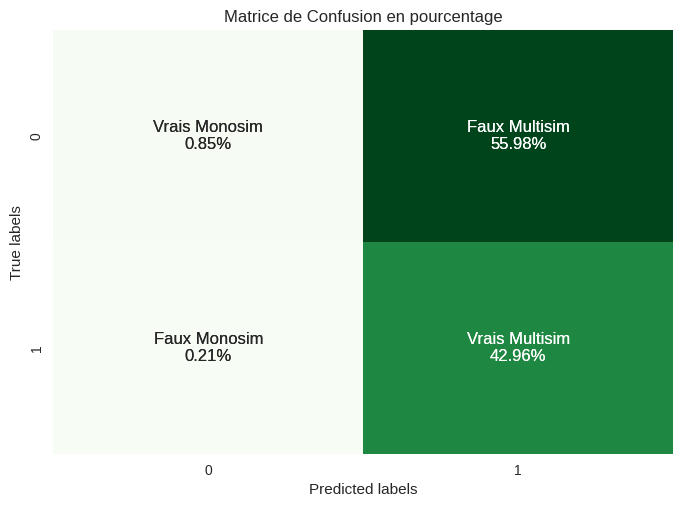

,Metrique,Score
0,Accuracy,44.0%
1,Précision,80.0%
2,Sensibilité,2.0%
3,F1 Score,4.0%


In [55]:
from sklearn.ensemble import AdaBoostClassifier

adaB = AdaBoostClassifier(n_estimators=85) #On crée notre AdaBoost
adaB.fit(X_train_scaled,y_train_final) #On la fit à nos données
adaB_pred =adaB.predict(X_test_final)# On prédit nos données

dict_models_pred['AdaBoost']=adaB_pred  #On ajoute les résultats dans notre dictionnaire


matrice_conf(y_test_final,adaB_pred) #Matrice de confusion
model_score(y_test_final,adaB_pred) #Score

### Gradient Booster

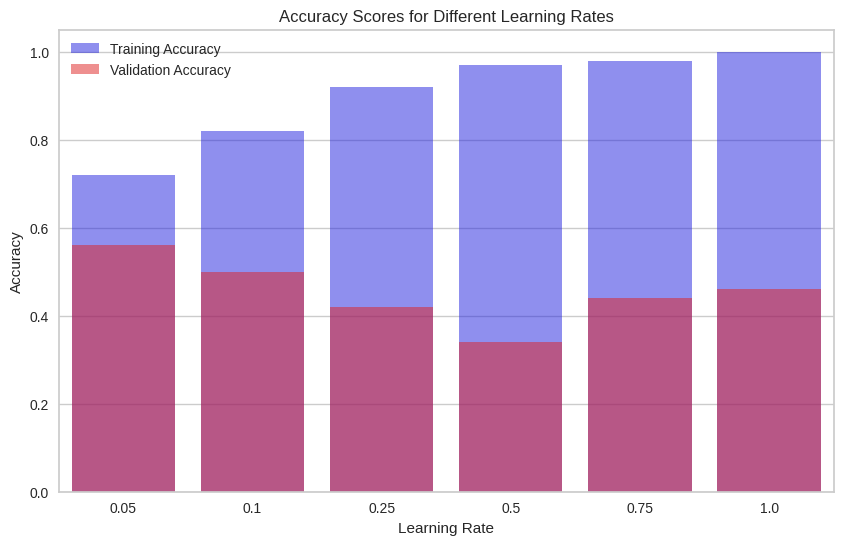

In [46]:
# import machine learning algorithms
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Données d'exemple pour X_train_final, y_train_final, X_test_final, y_test_final
# Remplacez-les par vos données réelles
X_train_final = np.random.rand(100, 10)
y_train_final = np.random.randint(0, 2, size=100)
X_test_final = np.random.rand(50, 10)
y_test_final = np.random.randint(0, 2, size=50)

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
train_scores = []
test_scores = []

for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb.fit(X_train_final, y_train_final)
    train_score = gb.score(X_train_final, y_train_final)
    test_score = gb.score(X_test_final, y_test_final)
    train_scores.append(train_score)
    test_scores.append(test_score)

# Création du graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=learning_rates, y=train_scores, color='blue', alpha=0.5, label='Training Accuracy')
sns.barplot(x=learning_rates, y=test_scores, color='red', alpha=0.5, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Learning Rates')
plt.legend()
plt.show()


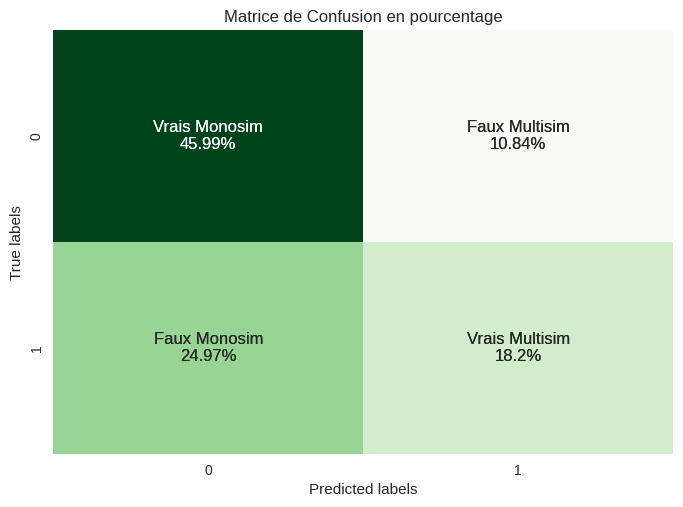

,Metrique,Score
0,Accuracy,64.0%
1,Précision,65.0%
2,Sensibilité,81.0%
3,F1 Score,72.0%


In [56]:
gbc = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.75, max_features=2, max_depth = 2, random_state = 0)
gbc.fit(X_train_final, y_train_final)
gbc_pred = gbc.predict(X_test_final)

dict_models_pred['Gradient Booster']=gbc_pred  #On ajoute les résultats dans notre dictionnaire

matrice_conf(y_test_final,gbc_pred) #Matrice de confusion
model_score(y_test_final,gbc_pred) #Score

### Perception Multicouche



Un réseau de neurones est un graphe orienté pondéré dont les nœuds sont appelés neurones artificiels et les arêtes (liens entre les nœuds) des synapses (l'idée originale du concept était d'essayer de reproduire le comportement des neurones du cerveau humain).

À chaque neurone est attribué un état interne appelé l'activation $ a \in \mathbb{R} $ et à chaque synapse est attribuée un poids $w \in \mathbb{R} $. Les poids sont répertoriés dans la matrice des poids $W$.

Le comportement d'un neurone artificiel est le suivant : un neurone $i$ reçoit des entrées $x_j$ (nombres réels) auxquels il applique une fonction d'entrée $h$, qui est le plus souvent la combinaison linéaire des entrées pondérée par les poids $w^i_j$ des synapses reliant les neurones d'entrée au neurone $i$. :

$h(x_1, \dots, x_d) = \displaystyle \sum_{j=1}^{d} w_{i,j}x_j$

Une fois cette transformation faite, le neurone $i$ applique au nombre obtenue une fonction d'activation $f$ (à valeurs dans $\mathbb{R}$), ce qui permet d'obtenir en sortie l'activation du neurone $i$.

Construire un réseau de neurones, c'est donc se fixer :

- Une architecture (nombre de neurones, connexions entre les neurones)
- Une matrice $W$ des poids des connexions entre les neurones (où l'absence de connexion se traduira par un poids égal à 0)
- Une fonction d'activation $f$

$f$ est généralement la même pour tous les neurones, ou du moins tous les neurones d'une même couche. Parmi les choix les plus fréquents pour $f$, on trouvera entre autres la sigmoïde exponentielle (vue plus haut), la tangente hyperbolique (ou sigmoïde tangentielle), ou bien encore la fonction partie positive (appelée alors unité de rectification linéaire ou ReLU en anglais).

<br>

Lorsque plusieurs couches de neurones se succèdent, un neurone prend en entrée les activations des neurones de la couche précédente et fournit son activation comme entrée pour les neurones de la couche suivante. C'est le cas par exemple d'un grand classique des réseaux de neurones que nous allons utiliser ici : le **Perceptron multicouche** (PMC)

Le PMC comporte :

- Une **couche d'entrée** où l'on rentrera les données d'observation. Cette couche aura donc $d$ neurones si on a $d$ variables explicatives
- Une **couche de sortie**, donnant la réponse, qui sera composée de 2 neurones dans le cas d'une classification supervisée avec variable cible binaire
- Et entre ces deux couches, une ou plusieurs **couches cachées**

Chaque neurone de chaque couche est connecté à tous les neurones de la couche précédente et à tous ceux de la couche suivante. On opère ainsi une suite de tranformations linéaires et d'application de fonctions d'activation.

<br>
<br>

Dans le cas d'un problème de classification binaire comme le nôtre, l'apprentissage d'un PMC se déroule comme suit : on dispose pour les $N$ individus de notre set d'entraînements des entrées $x^i_j$ (avec $i \in \{1,\dots,N\}$ et $j \in \{1,\dots,d\}$ assorties de la réponse effective $y_i$ (0 ou 1). Pour chaque individu $i$, on donnes les $x^i_j$ à la couche d'entrée et on obtient en sortie une probabilité $p_i$ que l'individu $i$ soit dans la classe 1 (on prend en fonction d'activation pour la couche de sortie la sigmoïde exponentielle, à valeurs comprises entre 0 et 1).

Ensuite on applique aux $p_i$ une fonction d'erreur, les **corrélations croisées** :

$logloss = - \displaystyle \frac{1}{N} \displaystyle \sum_{i=1}^{N} (y_iln(p_i) + (1-y_i)ln(1-p_i))$

(La sigmoïde exponentielle prend ses valeurs entre 0 et 1 **strictement** (limites non atteintes), donc il est bien licite de prendre le log des $p_i$ et $1-p_i$. On multiplie la somme par $(-1)$ pour avoir une valeur positive).

Et on va corriger les poids des synapses (initialisés arbitrairement au début) de façon à minimiser cette fonction d'erreur. Notre PMC ainsi entrainée pourra donc faire de la classification binaire.

<br>
<br>

On utilise Tensorflow et Keras pour créer notre PMC.
On initialise d'abord avec sequential() un modèle correspondant à la structure du PMC.
Puis avec add et la fonction Dense, on ajoute :

- La couche d'entrée avec 15 neurones (puisqu'on a 15 variables explicatives) et ReLU en fonction d'activation
- 3 couches cachées avec différents nombres de neurones et toujours ReLU en activation
- La couche de sortie, avec un seul neurone et donc la sigmoïde exponentielle en activation

(Pour le nombre de couches cachées et le nombre de neurones par couche cachée, nous avons testé différentes configurations et retenu celle qui donnait les meilleurs résultats. Il n'y a pas vraiment de méthode miracle pour trouver la bonne architecture avec le PMC, on doit donc en général procéder ainsi par tâtonnement).

Et on entraîne notre modèle avec compile en précisant qu'on veut les corrélations croisées comme fonction d'erreur :

In [ ]:
from tensorflow import keras

modelB=keras.models.Sequential()
modelB.add(keras.layers.Dense(15, activation='relu',input_dim=15))
modelB.add(keras.layers.Dense(13, activation='relu'))
modelB.add(keras.layers.Dense(11, activation='relu'))
modelB.add(keras.layers.Dense(7, activation='relu'))
modelB.add(keras.layers.Dense(5, activation='relu'))
modelB.add(keras.layers.Dense(3, activation='relu'))
modelB.add(keras.layers.Dense(1, activation='sigmoid'))

modelB.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history=modelB.fit(X_train_final,y_train_final,epochs=35,batch_size=2,verbose=0)
learning_curve_nn(history)

In [ ]:
nnB_pred=np.round(modelB.predict(X_test_final),0) #On prédit nos données

dict_models_pred['nnB']=nnB_pred #On l'ajoute à notre dictionnaire

model_score(y_test,nnB_pred) #Score
matrice_conf(y_test,nnB_pred) #Matrice de confusion

### VotingClassifier

Un Voting Classifier est un modèle qui s'entraîne sur un ensemble de modèle et qui prédit une sortie en croisant les résultats des différents modèles (au vote majoritaire). On commence par la base de données normale en utilisant les modèles utilisées précédemment.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


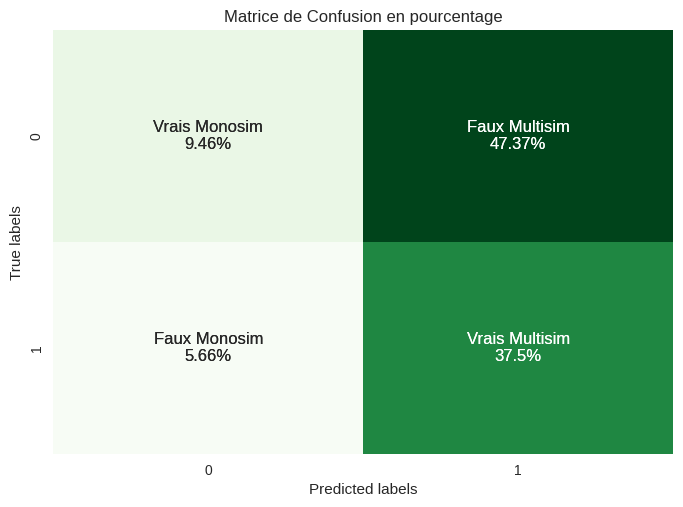

,Metrique,Score
0,Accuracy,47.0%
1,Précision,63.0%
2,Sensibilité,17.0%
3,F1 Score,27.0%


In [57]:
from sklearn.ensemble import VotingClassifier

#On crée notre VotingClassifier
vcB = VotingClassifier( estimators=[('logRegB',logRegB), ('rfB',rfB),("adaB",adaB)],voting='hard')

vcB.fit(X_train_scaled,y_train_final) #On entraine notre modèle
vcB_pred =vcB.predict(X_test_final)# On prédit nos données

dict_models_pred['Voting Classifier']=vcB_pred  #On ajoute les résultats dans notre dictionnaire


matrice_conf(y_test_final,vcB_pred) #Matrice de confusion
model_score(y_test_final,vcB_pred) #Score

## **Sélection du modèle, optimisation et validation**

On observe un récapitulatif de tout nos modèles avec leurs différents scores :

### Récapitulatf

In [58]:
recap_model(dict_models_pred,y_test_final)

,Accuracy,Précision,Sensibilité,Score F1,Somme
Régression logistique,0.61,0.60,0.89,0.72,2.82
Gradient Booster,0.64,0.65,0.81,0.72,2.82
KNN,0.58,0.58,0.93,0.72,2.81
Voting Classifier,0.47,0.63,0.17,0.26,1.53
Random Forest,0.45,0.55,0.19,0.28,1.47
AdaBoost,0.44,0.80,0.02,0.03,1.29


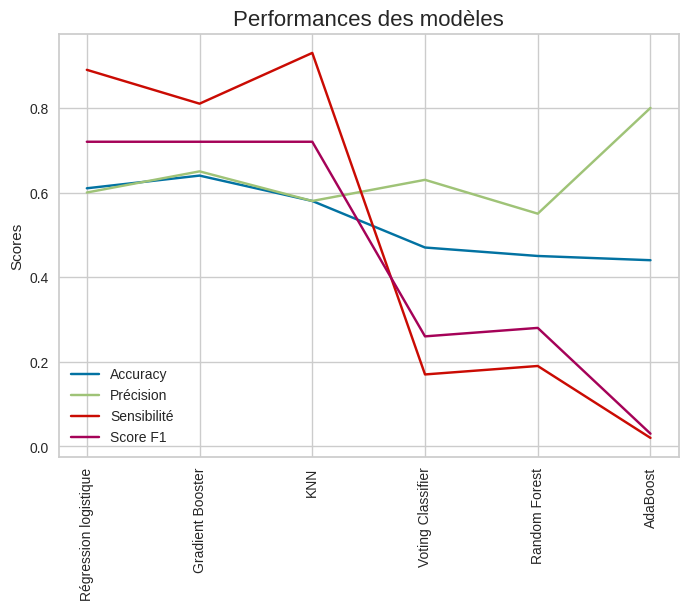

In [59]:
result = recap_model(dict_models_pred,y_test_final).sort_values(by = "Somme", ascending = False)
res_cols = ["Accuracy","Précision","Sensibilité","Score F1"]
result[res_cols].plot()
plt.xticks(rotation=90)
plt.legend(res_cols)
plt.ylabel("Scores")
plt.title("Performances des modèles", fontdict = {"fontsize": 16} );

Le meilleur modèle parmi tous ceux que l'on a testés semble être Régression Logistique les données normalisées.

On décide donc de retenir sur les données de base comme meilleur modèle. Maintenant qu'on a trouvé le meilleur modèle, il faut l'optimiser :

### Optimisation du modèle

La **validation croisée** (cross validation) consiste à découper notre data set en plusieurs parts égales et croiser différents processus d'apprentissage/test. Par exemple on divise les individus en 5 groupes A,B,C,D,E de taille égale. D'abord on entraîne le modèle sur A,B,C,D et on teste sur E. Puis on entraîne sur A,B,C,E et on teste sur D, et ainsi de suite. Finalement, on croise les résultats des 5 processus d'apprentissage/test. Cette technique, très souvent utilisée, permet d'avoir une estimation plus robuste de la validation du modèle.

On utilise **GridSearch** pour trouver les meilleurs hyperparamètres du modèle KNN. Un cross-valiation est effectué en même temps, ce qui rend les résultats plus robustes.

Le meilleur score pour la validation croisée est de 3.2, ce qui est inférieur au meilleur score (qui est de 3.28). La raison derrière cela est que la validation croisée effectuée lors de la recherche sur la grille ne tirera que de l'ensemble d'apprentissage en le divisant plusieurs fois en un nouvel ensemble d'apprentissage et un ensemble de validation. Par conséquent, le nombre d'observations sur lesquelles le modèle est réellement formé pour être optimisé est inférieur à celui d'avant. Cela se traduit par un score global inférieur, mais par une métrique de notation plus robuste, car le modèle est testé plusieurs fois dans plusieurs ensembles de tests différents à chaque étape de validation croisée.

La modèle optimal est donc les k plus proches voisins avec $k = 9$ et comme métrique la distance de Manhattan

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Création du modèle de régression logistique avec les hyperparamètres spécifiés
logRegV = LogisticRegression(penalty="l2", C=0.8)

# Calcul de la performance à l'aide de la validation croisée
scores = cross_val_score(logRegV, X_train_scaled, y_train_final, cv=5, scoring='accuracy') # Vous pouvez changer le score en fonction de vos besoins

# Affichage des scores de validation croisée pour chaque pli
print("Scores de validation croisée :", scores)

# Calcul de la moyenne et de l'écart-type des scores de validation croisée
print("Moyenne des scores de validation croisée :", scores.mean())
print("Écart-type des scores de validation croisée :", scores.std())


Scores de validation croisée : [0.6039198  0.60447262 0.60042631 0.60376813 0.60230495]
Moyenne des scores de validation croisée : 0.6029783633382189
Écart-type des scores de validation croisée : 0.0014635102929176325


Les performances du modèle ne se sont pas améliorées avec l'exécution de Gridsearch. Cependant, la validation croisée utilisée dans le processus fournit un modèle plus robuste. On utilise donc le modèle ci-dessus comme modèle final



## **Modèle final**

In [28]:
from sklearn.preprocessing import StandardScaler

# Séparation des features et de la cible
X_multisim = pd_reporting_multisim_fin.drop(["msisdn", "multi_sim"], axis=1)
y_multisim = pd_reporting_multisim_fin["multi_sim"]

# Split du dataset en ensemble d'entraînement et ensemble de test
X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(X_multisim , y_multisim, test_size=0.2, random_state=42)

# Standardisation des features (mise à l'échelle)
scaler = StandardScaler()
X_multisim_scaled = scaler.fit_transform(X_multisim)
X_total_multisim_scaled = scaler.fit_transform(pd_total_multisim_fin)
X_train_scaled_fin = scaler.fit_transform(X_train_fin)
X_test_scaled_fin= scaler.transform(X_test_fin)

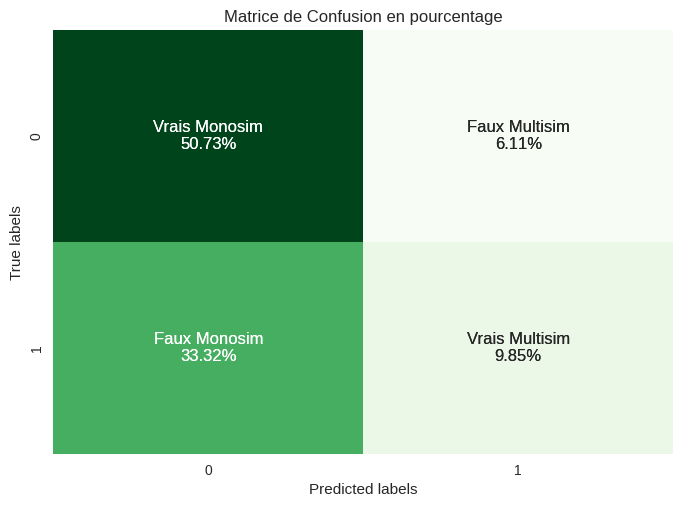

,Metrique,Score
0,Accuracy,61.0%
1,Précision,60.0%
2,Sensibilité,89.0%
3,F1 Score,72.0%


In [27]:
logRegT = LogisticRegression(penalty = "l2", C = 0.8)#On crée notre régression logistique
logRegT.fit(X_train_scaled_fin,y_train_fin)#On la fit à nos données
logRegT_pred = logRegT.predict(X_test_scaled_fin)# On prédit nos données

matrice_conf(y_test_fin,logRegT_pred)# Matrice de confusion
model_score(y_test_fin,logRegT_pred) #Score

In [ ]:
pd_total_multisim_pred=pd_total_multisim_fin.copy()
logRegF = LogisticRegression(penalty = "l2", C = 0.8)#On crée notre régression logistique
logRegF.fit(X_multisim,y_multisim)#On la fit à nos données
logRegF_proba = logRegF.predict_proba(pd_total_multisim_pred.drop("numero",axis=1))[:, 1]# On prédit nos données
pd_total_multisim_pred["proba_multisim"]=logRegF_proba

In [35]:
# Déplacer la colonne "Probability" en deuxième position
pd_total_multisim_last=pd_total_multisim_pred.copy()
pd_total_multisim_last['proba_multisim'] = pd_total_multisim_last['proba_multisim'].map(lambda x: '{:.1%}'.format(x))
cols = list(pd_total_multisim_last.columns)
cols.insert(1, cols.pop(cols.index('proba_multisim')))
pd_total_multisim_last = pd_total_multisim_fin.reindex(columns=cols)
pd_total_multisim_last.head()

## **Exploration des résultats**